<a href="https://colab.research.google.com/github/malowana/NLPDisasterTweets/blob/main/NLP_Disaster_Tweets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [2]:
!pip3 install catboost

     |████████████████████████████████| 65.7MB 44kB/s 


In [3]:
!pip install scikit-plot

In [2]:
cd '/content/drive/My Drive/Konkursy Kaggle/Disaster Tweets'

/content/drive/My Drive/Konkursy Kaggle/Disaster Tweets


Data taken from https://www.kaggle.com/c/nlp-getting-started/data


In [3]:
train = pd.read_csv('/content/drive/My Drive/Konkursy Kaggle/Disaster Tweets/train.csv').reset_index(drop=True)
test = pd.read_csv('/content/drive/My Drive/Konkursy Kaggle/Disaster Tweets/test.csv').reset_index(drop=True)

In [4]:
train.sample(10)

,id,keyword,location,text,target
2616,3754,destruction,"Georgia, USA",@cinla1964 @windowgatribble The Contrasts of F...,0
1235,1776,buildings%20on%20fire,"Tulsa, Oklahoma",Multiple Buildings On Fire In Downtown Hinton ...,1
2458,3526,derailment,India,Railway Minister Prabhu calls MP derailment a ...,1
7569,10819,wrecked,"Livingston, MT",@marynmck That's beyond adorable. I hope it wo...,0
2476,3550,derailment,India,Helping Hand: In Mumbai 2 TTEs take charge of ...,1
4641,6598,inundated,The windy plains of Denver,@VZWSupport do texts use data? She was inundat...,0
2264,3244,deluged,NaN,Businesses are|deluged with invoices. Make y u...,0
3967,5638,flooding,"California, USA",So grateful for all the support flooding in fr...,1
3313,4747,evacuate,Nashville,@ahhtheenikki And from what I can tell- they r...,1
3109,4463,electrocuted,USA,South Side factory where worker electrocuted p...,1


Check if there are missing values and fill it

In [5]:
def is_missing(train):
  for column in train.columns:
      missing = column, train[column].isnull().sum()
      if missing[1] == 0: continue
      print(missing)

is_missing(train)
is_missing(test)

('keyword', 61)
('location', 2533)
('keyword', 26)
('location', 1105)


In [6]:
train = train.fillna("other")
test = test.fillna("other")

In [7]:
#concatenate the subsets
all = pd.concat([train, test], sort=False)

In [8]:
all.head()

,id,keyword,location,text,target
0,1,other,other,Our Deeds are the Reason of this #earthquake M...,1.0
1,4,other,other,Forest fire near La Ronge Sask. Canada,1.0
2,5,other,other,All residents asked to 'shelter in place' are ...,1.0
3,6,other,other,"13,000 people receive #wildfires evacuation or...",1.0
4,7,other,other,Just got sent this photo from Ruby #Alaska as ...,1.0


Data cleanup

In [9]:
all.keyword.value_counts()

other                    87
wreck                    50
ablaze                   50
crash                    50
annihilated              50
                         ..
forest%20fire            24
threat                   16
inundation               14
radiation%20emergency    14
epicentre                13
Name: keyword, Length: 222, dtype: int64

In [10]:
#keywords
all.loc[all['keyword'].str.contains('murder|bag'), 'keyword'] = 'murder'
all.loc[all['keyword'].str.contains('fire|burn'), 'keyword'] = 'fire'
all.loc[all['text'].str.contains('fire'), 'keyword'] = 'fire'
all.loc[all['keyword'].str.contains('radiation|nuclear|chemical|oil'), 'keyword'] = 'bioterrorism'
all.loc[all['keyword'].str.contains('bomb|loud'), 'keyword'] = 'bomb'
all.loc[all['text'].str.contains('bomb|explode|loud'), 'keyword'] = 'bomb'
all.loc[all['keyword'].str.contains('inundation'), 'keyword'] = 'flooding'
all.loc[all['text'].str.contains('flood|Flood'), 'keyword'] = 'flooding'
all.loc[all['keyword'].str.contains('war|battle|structural'), 'keyword'] = 'war'
all.loc[all['keyword'].str.contains('epicentre|bridge|cliff'), 'keyword'] = 'earthquake'
all.loc[all['text'].str.contains('earthquake|EARTHQUAKE|Earthquake|bridge'), 'keyword'] = 'earthquake'
all.loc[all['keyword'].str.contains('threat|violent'), 'keyword'] = 'danger'
all.loc[all['text'].str.contains('Violent'), 'keyword'] = 'danger'
all.loc[all['keyword'].str.contains('emergency'), 'keyword'] = 'emergency'
all.loc[all['text'].str.contains('emergency'), 'keyword'] = 'emergency'
all.loc[all['keyword'].str.contains('blew|blown|dust'), 'keyword'] = 'windstorm'
all.loc[all['text'].str.contains('hurricane|tornado'), 'keyword'] = 'windstorm'
all.loc[all['keyword'].str.contains('airplane'), 'keyword'] = 'crash'
all.loc[all['text'].str.contains('crash|car'), 'keyword'] = 'crash'
all.loc[all['keyword'].str.contains('first'), 'keyword'] = 'rescued'
all.loc[all['keyword'].str.contains('disaster'), 'keyword'] = 'disaster'
all.loc[all['text'].str.contains('heat|Heat'), 'keyword'] = 'heat'

In [11]:
all.loc[all['keyword']=='other' ]

,id,keyword,location,text,target
2,5,other,other,All residents asked to 'shelter in place' are ...,1.0
15,23,other,other,What's up man?,0.0
16,24,other,other,I love fruits,0.0
17,25,other,other,Summer is lovely,0.0
19,28,other,other,What a goooooooaaaaaal!!!!!!,0.0
20,31,other,other,this is ridiculous....,0.0
21,32,other,other,London is cool ;),0.0
22,33,other,other,Love skiing,0.0
23,34,other,other,What a wonderful day!,0.0
24,36,other,other,LOOOOOOL,0.0


In [12]:
#location
all.loc[all['location'].str.contains('Iraq|Pakistan'), 'location'] = 'Asia'
all.loc[all['location'].str.contains('Las Vegas'), 'location'] = 'Las Vegas'
all.loc[all['location'].str.contains('Irleand|Dublin'), 'location'] = 'Irleand'
all.loc[all['location'].str.contains('OH|Ohio'), 'location'] = 'Ohio'
all.loc[all['location'].str.contains('Brazil'), 'location'] = 'Brasil'
all.loc[all['location'].str.contains('MO|Kansas City'), 'location'] = 'Missouri'
all.loc[all['location'].str.contains('umbai|India'), 'location'] = 'India'
all.loc[all['location'].str.contains('Italy|France|Switzerland|Netherlands|Germany|Sweden|Geneva|Rome|Spain'), 'location'] = 'Europe'
all.loc[all['location'].str.contains('Nigeria|Lagos'), 'location'] = 'Nigeria'
all.loc[all['location'].str.contains('Japan|Tokyo'), 'location'] = 'Japan'
all.loc[all['location'].str.contains('Virginia|VA'), 'location'] = 'Virginia'
all.loc[all['location'].str.contains('Hong Kong|china|China'), 'location'] = 'China'
all.loc[all['location'].str.contains('Edinburgh'), 'location'] = 'Scotland'
all.loc[all['location'].str.contains('NC|North Carolina'), 'location'] = 'North Carolina'
all.loc[all['location'].str.contains('Portland'), 'location'] = 'Portland'
all.loc[all['location'].str.contains('Boston|WI|PA|IA|Poenix|Georgia|America|United States|Unites States|U.S.A|US|U.S.|Wisconsin|New Hampshire|Arizona|Midwest|Indiana|Maryland|Pennsylvania|Puerto Rico|Oregon|Michigan'), 'location'] = 'USA'
all.loc[all['location'].str.contains('NJ|NY|New York|NYC|york|nyc'), 'location'] = 'New York'
all.loc[all['location'].str.contains('Sydney'), 'location'] = 'Sydney'
all.loc[all['location'].str.contains('ondon|United Kingdom|England|Coventry|Birmingham|Paignton|Liverpool|Glasgow|Newcastle|UK|Manchester'), 'location'] = 'UK'
all.loc[all['location'].str.contains('Australia|Melbourne|Sydney'), 'location'] = 'Australia'
all.loc[all['location'].str.contains('California|San Diego|Sacramento|San Francisco'), 'location'] = 'California'
all.loc[all['location'].str.contains('Washington'), 'location'] = 'Washington'
all.loc[all['location'].str.contains('Chicago'), 'location'] = 'Chicago'
all.loc[all['location'].str.contains('Los Angeles|Subconscious|LA'), 'location'] = 'Los Angeles'
all.loc[all['location'].str.contains('Seattle, WA'), 'location'] = 'Seattle'
all.loc[all['location'].str.contains('World|orldwide|Earth|Global|The Universe'), 'location'] = 'Everywhere'
all.loc[all['location'].str.contains('TX|Texas|Houston'), 'location'] = 'Texas'
all.loc[all['location'].str.contains('CA|Canada|Toronto|Vancouver|canada|Calgary'), 'location'] = 'Canada'
all.loc[all['location'].str.contains('TN'), 'location'] = 'Tennessee'
all.loc[all['location'].str.contains('FL|Orlando'), 'location'] = 'Florida'
all.loc[all['location'].str.contains('304|house|hell|Taylor|Tunes|stairs|Coffee|ss|Money|Happily Married|MAD as Hell|Billionaires|Word|Pedophile|Narnia|Your screen|Here|Jupiter|Anonymous|really|Breaking|where|All|Some|Innerhalb|Sky|BROKE|Can|Sky'), 'location'] = 'other'
all.loc[all['location'].str.contains('Lagos'), 'location'] = 'Lagos'
all.loc[all['location'].str.contains('Denver'), 'location'] = 'Denver'
all.loc[all['location'].str.contains('New Jersey'), 'location'] = 'New Jersey'
all.loc[all['location'].str.contains('Calgary'), 'location'] = 'Calgary'
all.loc[all['location'].str.contains('Atlanta|atlanta'), 'location'] = 'Atlanta'
all.loc[all['location'].str.contains('Detroit'), 'location'] = 'Michigan'


# occur <20 times -> change to 'other'
ln = all.groupby('location').location.count().sort_values(ascending=False)
ln = ln[ln.values <= 20].index

for loc in ln:
    all.loc[(all.location == loc), 'location'] = 'other'
all.groupby('location').location.count().sort_values()

location
China               21
Portland            21
Las Vegas           25
Atlanta             26
New Jersey          27
Seattle             28
Asia                31
Denver              31
Japan               31
Kenya               32
Virginia            61
Chicago             63
Ohio                63
North Carolina      82
Washington          88
Nigeria             90
Florida             92
Europe              94
Los Angeles         99
Australia          117
India              127
Texas              149
California         161
New York           352
UK                 428
USA                736
other             7801
Name: location, dtype: int64

In [13]:
#new features
all['length_text'] = all['text'].str.len()
all['length_keyword'] = all['keyword'].str.len()
all['length_location'] = all['location'].str.len()
all['word_count'] = all['text'].str.split().str.len()
all['is_upper_text'] = all['text'].str.count(r'[A-Z]')
all['is_digit_text'] = all['text'].str.count(r'[0-9]')
all['%_upper_text'] = all['is_upper_text']/all['length_text']
all['is_#'] = all['text'].str.count(r'#')
all.loc[(all['text'].str.contains("http")), 'is_url'] = 1
all.loc[all['is_url'].isnull(), 'is_url'] = 0
all['is_@'] = all['text'].str.count(r'@')

In [14]:
all.head(20)

,id,keyword,location,text,target,length_text,length_keyword,length_location,word_count,is_upper_text,is_digit_text,%_upper_text,is_#,is_url,is_@
0,1,earthquake,other,Our Deeds are the Reason of this #earthquake M...,1.0,69,10,5,13,10,0,0.144928,1,0.0,0
1,4,fire,other,Forest fire near La Ronge Sask. Canada,1.0,38,4,5,7,5,0,0.131579,0,0.0,0
2,5,other,other,All residents asked to 'shelter in place' are ...,1.0,133,5,5,22,2,0,0.015038,0,0.0,0
3,6,fire,other,"13,000 people receive #wildfires evacuation or...",1.0,65,4,5,8,1,5,0.015385,1,0.0,0
4,7,fire,other,Just got sent this photo from Ruby #Alaska as ...,1.0,88,4,5,16,3,0,0.034091,2,0.0,0
5,8,fire,other,#RockyFire Update => California Hwy. 20 closed...,1.0,110,4,5,18,9,2,0.081818,3,0.0,0
6,10,flooding,other,#flood #disaster Heavy rain causes flash flood...,1.0,95,8,5,14,4,0,0.042105,2,0.0,0
7,13,fire,other,I'm on top of the hill and I can see a fire in...,1.0,59,4,5,15,2,0,0.033898,0,0.0,0
8,14,emergency,other,There's an emergency evacuation happening now ...,1.0,79,9,5,12,1,0,0.012658,0,0.0,0
9,15,windstorm,other,I'm afraid that the tornado is coming to our a...,1.0,52,9,5,10,1,0,0.019231,0,0.0,0


In [77]:
import re
def re_urls(text, replace_for="URL"):
    return re.sub(r'https?://\S+', replace_for, text) 

def re_digits(text, replace_for=' '): 
    result = re.sub(r'\d+', replace_for, text) 
    return result

def preprocessing(doc):
    doc = re_urls(doc)
    doc = re_digits(doc)
    return doc

all['text_aprep'] = all['text'].map(preprocessing).values

In [78]:
#split to test/train again
train2 = all[ ~all['target'].isnull() ].copy()
test2 = all[ all['target'].isnull() ].copy()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


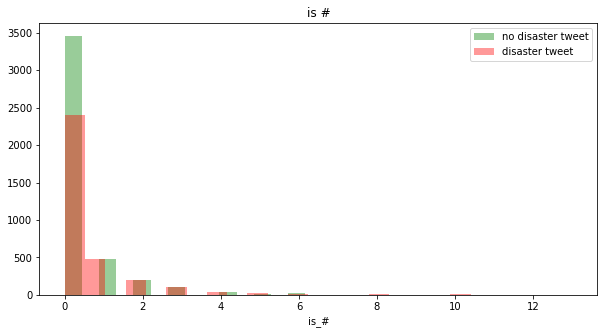

In [ ]:
plt.figure(figsize=(10,5))
fig = sns.distplot(a=train2[train2['target']==0.0]["is_#"], 
                   hist=True, bins=25, kde=False, color="green", 
                   label='no disaster tweet')
fig = sns.distplot(a=train2[train2['target']==1.0]["is_#"], 
                   hist=True, bins=25, kde=False, color="red", 
                   label='disaster tweet')
fig.legend()
fig.set(title='is #');

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


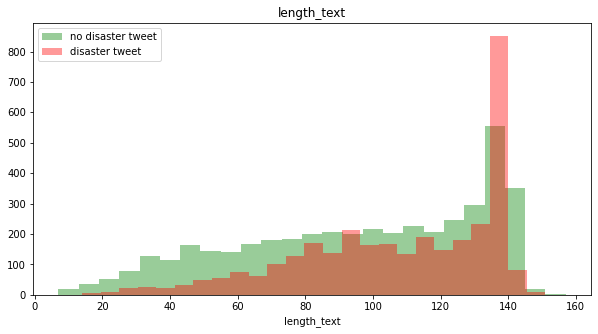

In [ ]:

plt.figure(figsize=(10,5))
fig = sns.distplot(a=train2[train2['target']==0.0]["length_text"], 
                   hist=True, bins=25, kde=False, color="green", 
                   label='no disaster tweet')
fig = sns.distplot(a=train2[train2['target']==1.0]["length_text"], 
                   hist=True, bins=25, kde=False, color="red", 
                   label='disaster tweet')
fig.legend()
fig.set(title='length_text');

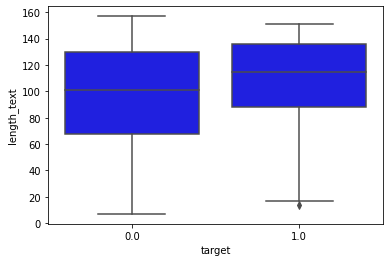

In [ ]:
ax = sns.boxplot(x="target", y="length_text", data=train2, orient='v', color = 'blue')

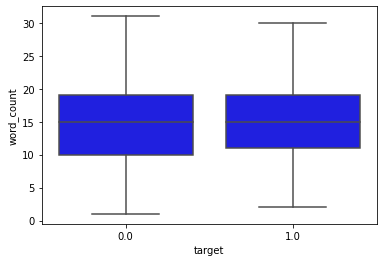

In [ ]:
ax = sns.boxplot(x="target", y="word_count", data=train2, orient='v', color = 'blue')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


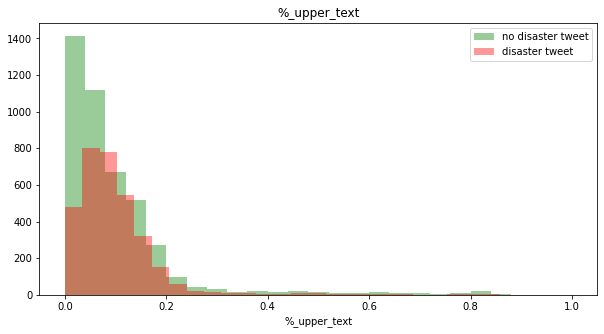

In [ ]:
plt.figure(figsize=(10,5))
fig = sns.distplot(a=train2[train2['target']==0.0]["%_upper_text"], 
                   hist=True, bins=25, kde=False, color="green", 
                   label='no disaster tweet')
fig = sns.distplot(a=train2[train2['target']==1.0]["%_upper_text"], 
                   hist=True, bins=25, kde=False, color="red", 
                   label='disaster tweet')
fig.legend()
fig.set(title='%_upper_text');

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


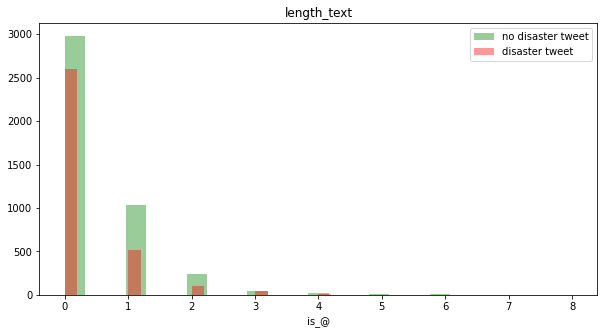

In [ ]:

plt.figure(figsize=(10,5))
fig = sns.distplot(a=train2[train2['target']==0.0]["is_@"], 
                   hist=True, bins=25, kde=False, color="green", 
                   label='no disaster tweet')
fig = sns.distplot(a=train2[train2['target']==1.0]["is_@"], 
                   hist=True, bins=25, kde=False, color="red", 
                   label='disaster tweet')
fig.legend()
fig.set(title='length_text');

## **Fast** **Text**

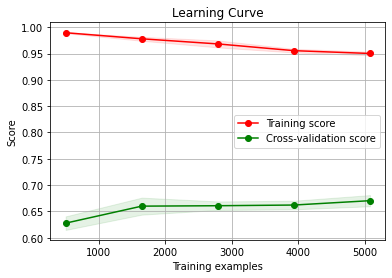

In [ ]:
from gensim.utils import simple_preprocess
import catboost as ctb
from gensim.models import FastText
from scikitplot.estimators import plot_learning_curve

train2['simple_tokens'] = train2['text_aprep'].map(simple_preprocess)

model = FastText(train2['simple_tokens'], size=50, window=3, seed=0)

 #funkcja get_doc2vec_X z wektoryzajca i policzona srednia z wektorow
def get_doc2vec_X(model, tokens):
    def __calc_doc2vec(words):   #wektoryzacja
        return np.mean([model.wv[w] for w in words if w in model.wv], axis=0)

    X = tokens.map(__calc_doc2vec)
    default_vector = X[ False == X.isnull() ].mean()
    return np.stack( X.map(lambda x: default_vector if str(x) == 'nan' else x) )


model = FastText(train2['simple_tokens'], size=100, window=4, seed=0)
X = get_doc2vec_X(model, train2['simple_tokens'])
y = train2['target'].factorize()[0]

fasttext_model = ctb.CatBoostClassifier(max_depth=10, n_estimators=300, verbose=0, random_state=0, custom_metric='AUC')
fasttext_model.fit(X, y)
plot_learning_curve(fasttext_model, X, y, cv=3, random_state=2019, shuffle=True)

In [ ]:
test2['simple_tokens'] = test2['text_aprep'].map(simple_preprocess)
X_test = get_doc2vec_X(model, test2['simple_tokens'])


test2['target'] = fasttext_model.predict(X_test).astype('int32')
test2[[ 'id', 'target'] ].sample(20)

,id,target
2503,8340,1
2495,8325,1
1588,5369,1
2652,8868,1
2097,7035,1
2392,7997,1
1650,5562,1
1081,3563,1
2537,8467,1
2131,7127,1


In [ ]:
test[ ['id', 'target'] ].to_csv('fasttext.csv', index=False)
#Kaggle score:  0.29206

## **BERT**

Pretrained model avaiable on [github](https://github.com/google-research/bert).

In [20]:
!pip install keras_bert

  Created wheel for keras-bert: filename=keras_bert-0.86.0-cp37-none-any.whl size=34144 sha256=6d7993e9406fcab42e97c574cac40093311ef8510cff2fc831b1b9aeb0b51833
  Stored in directory: /root/.cache/pip/wheels/66/f0/b1/748128b58562fc9e31b907bb5e2ab6a35eb37695e83911236b
  Created wheel for keras-transformer: filename=keras_transformer-0.38.0-cp37-none-any.whl size=12942 sha256=158a5fb566c7cd14fbbb4081cd8d162a6d85df5d8399d9664e387580e102bbbe
  Stored in directory: /root/.cache/pip/wheels/e5/fb/3a/37b2b9326c799aa010ae46a04ddb04f320d8c77c0b7e837f4e
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp37-none-any.whl size=7554 sha256=db5d06a63a0e3b875fcc65e513c4d7a2371a4f431f84504fc4836b44f63424ec
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.27.0-cp37-none-any.whl size=15611 sha256=536c85b60439ac1449a3839a0a7200c08dbf3673239a290f01a34cdaf57a66c7
  Stor

In [21]:
!pip install transformers

     |████████████████████████████████| 1.9MB 18.3MB/s 
     |████████████████████████████████| 890kB 53.6MB/s 
     |████████████████████████████████| 3.2MB 49.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=9ca491df19180888e827ea5ab01ffd80b6e2c533a8dcf051497f3dca604f7e4e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [18]:
from keras_bert import load_trained_model_from_checkpoint
from transformers import BertTokenizer

In [19]:
bert_model = 'uncased_L-12_H-768_A-12'
tokenizer = BertTokenizer.from_pretrained('uncased_L-12_H-768_A-12/vocab.txt', do_lower_case=True) #load wocabulary
model = load_trained_model_from_checkpoint('uncased_L-12_H-768_A-12/bert_config.json', 'uncased_L-12_H-768_A-12/bert_model.ckpt')

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated


In [20]:
def get_vectors(tokenizer, dataframe, col_name):
    tokenize = lambda sentence: tokenizer.encode_plus(sentence, max_length=512, padding='max_length', truncation=True) #add [CSL/SEP]
    dataframe['tokens'] = dataframe[col_name].map(tokenize)

    #keys
    dataframe['input_ids'] = dataframe['tokens'].map(lambda x: x['input_ids'])
    dataframe['token_type_ids'] = dataframe['tokens'].map(lambda x: x['token_type_ids'])
    
    #zmienia liste w liscie na macierz
    input_ids = np.stack(dataframe['input_ids']) 
    token_type_ids = np.stack(dataframe['token_type_ids'])

    vectors = {'input_ids': input_ids, 'token_type_ids': token_type_ids}
    return vectors

In [21]:
def bert_predict_in_batches(vectors, num_batches, output_shape):

  vector_input_ids_batches = np.array_split(vectors['input_ids'], num_batches)
  vector_token_type_ids_batches = np.array_split(vectors['token_type_ids'], num_batches)
  

  X = np.array([]).reshape((0, output_shape))
  model = load_trained_model_from_checkpoint('uncased_L-12_H-768_A-12/bert_config.json', 'uncased_L-12_H-768_A-12/bert_model.ckpt', training=False)
  input_vectors = zip(vector_input_ids_batches, vector_token_type_ids_batches)
  for input_ids, token_type_ids in input_vectors:
    all_vectors = (input_ids, token_type_ids)
    predictions = model.predict(all_vectors, verbose=1)

    X_batch = predictions[:, 0, :]
    print('current predictions shape: ', X_batch.shape)
    X = np.concatenate([X, X_batch])
    print('all predictions shape: ', X.shape)

  return X

In [22]:
bert_vectors = get_vectors(tokenizer, test2, 'text_aprep')

In [51]:
bert_output_shape = model.layers[-1].output_shape[2]

In [52]:
test_X_text_aprep = bert_predict_in_batches(bert_vectors, 10, bert_output_shape)
np.save('test_X_text_aprep.npy', test_X_text_aprep)

11/11 [==============================] - 20s 1s/step
current predictions shape:  (327, 768)
all predictions shape:  (327, 768)
11/11 [==============================] - 15s 1s/step
current predictions shape:  (327, 768)
all predictions shape:  (654, 768)
11/11 [==============================] - 16s 1s/step
current predictions shape:  (327, 768)
all predictions shape:  (981, 768)
11/11 [==============================] - 16s 1s/step
current predictions shape:  (326, 768)
all predictions shape:  (1307, 768)
11/11 [==============================] - 15s 1s/step
current predictions shape:  (326, 768)
all predictions shape:  (1633, 768)
11/11 [==============================] - 15s 1s/step
current predictions shape:  (326, 768)
all predictions shape:  (1959, 768)
11/11 [==============================] - 15s 1s/step
current predictions shape:  (326, 768)
all predictions shape:  (2285, 768)
11/11 [==============================] - 15s 1s/step
current predictions shape:  (326, 768)
all predictions

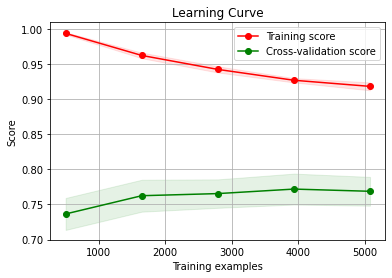

In [55]:
import catboost as ctb
from scikitplot.estimators import plot_learning_curve
X_train = np.load("train_X_text_aprep.npy")
X_test = np.load("test_X_text_aprep.npy")

y_train = train2['target'].values

model = ctb.CatBoostClassifier(max_depth=5, n_estimators=100, verbose=0, random_state=0, custom_metric='AUC')
model.fit(X_train, y_train)
plot_learning_curve(model, X_train, y_train, cv=3, random_state=2019, shuffle=True)

In [56]:

test2['target'] = model.predict(X_test).astype('int32')
test2[[ 'id', 'target'] ].sample(20)

,id,target
245,785,0
2322,7776,0
810,2662,0
1015,3333,0
1613,5435,1
2811,9349,1
61,202,0
436,1413,0
794,2613,0
1042,3424,0


In [57]:
test2[ ['id', 'target'] ].to_csv('bert_aprep.csv', index=False)

Kaggle score: 0.77597

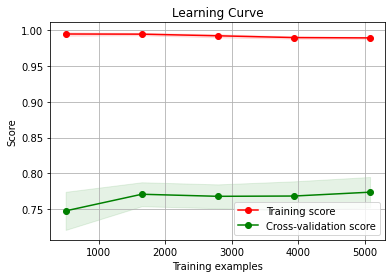

In [58]:
import catboost as ctb
from scikitplot.estimators import plot_learning_curve
X_train = np.load("train_X_text_aprep.npy")
X_test = np.load("test_X_text_aprep.npy")

y_train = train2['target'].values

model = ctb.CatBoostClassifier(max_depth=8, n_estimators=200, verbose=0, random_state=0, custom_metric='AUC')
model.fit(X_train, y_train)
plot_learning_curve(model, X_train, y_train, cv=3, random_state=2019, shuffle=True)

In [60]:
test2['target'] = model.predict(X_test).astype('int32')
test2[ ['id', 'target'] ].to_csv('bert_aprep2.csv', index=False)

Kaggle score: 0.78486

## **Hero+Bert**

In [ ]:
!pip install texthero

In [23]:
import texthero as hero

In [79]:
train2["text_clean"] = hero.clean(train2["text_aprep"])
test2["text_clean"] = hero.clean(test2["text_aprep"])

In [80]:
train2.head()

,id,keyword,location,text,target,length_text,length_keyword,length_location,word_count,is_upper_text,is_digit_text,%_upper_text,is_#,is_url,is_@,text_aprep,text_clean
0,1,earthquake,other,Our Deeds are the Reason of this #earthquake M...,1.0,69,10,5,13,10,0,0.144928,1,0.0,0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us
1,4,fire,other,Forest fire near La Ronge Sask. Canada,1.0,38,4,5,7,5,0,0.131579,0,0.0,0,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada
2,5,other,other,All residents asked to 'shelter in place' are ...,1.0,133,5,5,22,2,0,0.015038,0,0.0,0,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...
3,6,fire,other,"13,000 people receive #wildfires evacuation or...",1.0,65,4,5,8,1,5,0.015385,1,0.0,0,", people receive #wildfires evacuation order...",people receive wildfires evacuation orders cal...
4,7,fire,other,Just got sent this photo from Ruby #Alaska as ...,1.0,88,4,5,16,3,0,0.034091,2,0.0,0,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...


In [67]:
bert_model = 'uncased_L-12_H-768_A-12'
tokenizer = BertTokenizer.from_pretrained('uncased_L-12_H-768_A-12/vocab.txt', do_lower_case=True) #load wocabulary
model = load_trained_model_from_checkpoint('uncased_L-12_H-768_A-12/bert_config.json', 'uncased_L-12_H-768_A-12/bert_model.ckpt')

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated


In [71]:
bert_vectors = get_vectors(tokenizer, train2, 'text_clean')

In [72]:
bert_output_shape = model.layers[-1].output_shape[2]

In [73]:
train_X_text_clean = bert_predict_in_batches(bert_vectors, 10, bert_output_shape)
np.save('train_X_text_clean.npy', train_X_text_clean)

24/24 [==============================] - 37s 1s/step
current predictions shape:  (762, 768)
all predictions shape:  (762, 768)
24/24 [==============================] - 34s 1s/step
current predictions shape:  (762, 768)
all predictions shape:  (1524, 768)
24/24 [==============================] - 34s 1s/step
current predictions shape:  (762, 768)
all predictions shape:  (2286, 768)
24/24 [==============================] - 35s 1s/step
current predictions shape:  (761, 768)
all predictions shape:  (3047, 768)
24/24 [==============================] - 35s 1s/step
current predictions shape:  (761, 768)
all predictions shape:  (3808, 768)
24/24 [==============================] - 35s 1s/step
current predictions shape:  (761, 768)
all predictions shape:  (4569, 768)
24/24 [==============================] - 35s 1s/step
current predictions shape:  (761, 768)
all predictions shape:  (5330, 768)
24/24 [==============================] - 35s 1s/step
current predictions shape:  (761, 768)
all predictio

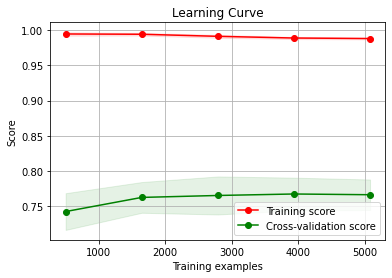

In [74]:
import catboost as ctb
from scikitplot.estimators import plot_learning_curve
X_train = np.load("train_X_text_clean.npy")
X_test = np.load("test_X_text_clean.npy")

y_train = train2['target'].values

model = ctb.CatBoostClassifier(max_depth=8, n_estimators=200, verbose=0, random_state=0, custom_metric='AUC')
model.fit(X_train, y_train)
plot_learning_curve(model, X_train, y_train, cv=3, random_state=2019, shuffle=True)

In [75]:
test2['target'] = model.predict(X_test).astype('int32')
test2[ ['id', 'target'] ].to_csv('bert_clean.csv', index=False)

Kaggle score: 0.78669

# **Topic modelling**

In [148]:
all["text_clean"] = hero.clean(all["text_aprep"])

In [149]:
all.loc[all['text_clean'].str.len() <3, 'text_clean'] = 'empty'

In [150]:
embeddings = DocumentPoolEmbeddings(
    [WordEmbeddings('glove')],
    pooling='mean', #max, min
)

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:479: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information



In [151]:
token_all = all.text_clean.map(simple_preprocess)  #tokenization

In [152]:
def calc_embeddings(text, embeddings):
    sent = Sentence(text)
    embeddings.embed(sent)
    return sent.embedding.cpu().numpy()
    

%time all['vectors'] = token_all.map(lambda text: calc_embeddings(text, embeddings))

CPU times: user 6.31 s, sys: 78.1 ms, total: 6.39 s
Wall time: 6.39 s


In [153]:
%time all['10topics'] = hero.kmeans(all['vectors'], n_clusters=10)
all['10topics'].value_counts()

CPU times: user 84 ms, sys: 10.9 ms, total: 94.9 ms
Wall time: 2.64 s


7    1685
1    1533
2    1385
3    1244
4    1229
5     986
6     805
9     767
8     689
0     553
Name: 10topics, dtype: int64

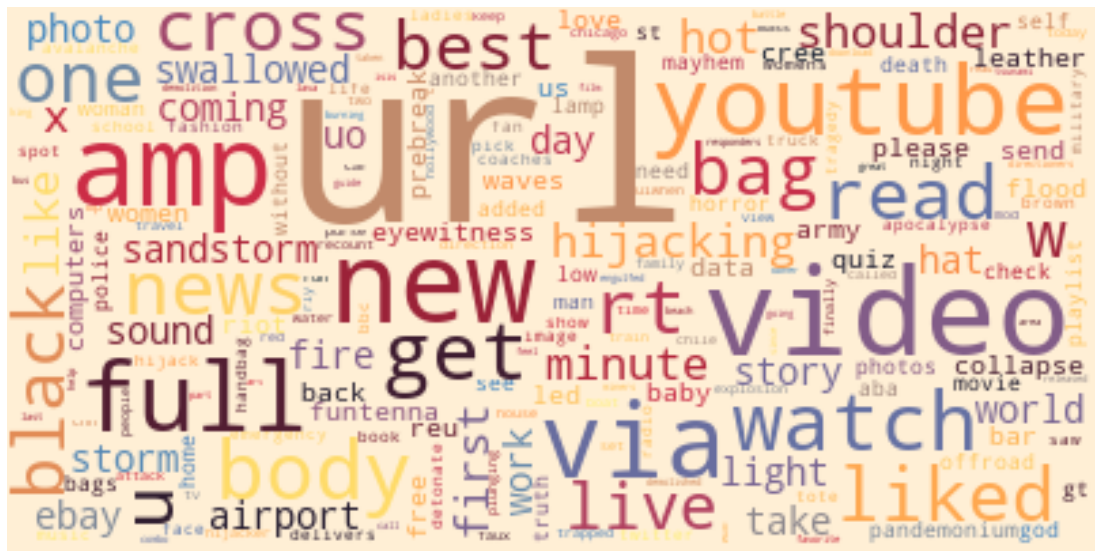

In [155]:
hero.visualization.wordcloud(all[all['10topics'] == 7]['text_clean'])

In [157]:
hero.visualization.top_words(all[all['10topics'] == 7]['text_clean']).head(30)

url          1896
video         141
amp           121
new           120
via            98
youtube        92
full           89
body           66
watch          64
get            63
news           53
rt             52
u              49
cross          49
read           49
liked          48
bag            44
black          43
one            42
best           42
w              40
hijacking      39
live           39
minute         38
shoulder       38
x              37
first          37
hot            36
airport        35
sandstorm      35
Name: text_clean, dtype: int64

In [158]:
#split to test/train again
train3 = all[ ~all['target'].isnull() ].copy()
test3 = all[ all['target'].isnull() ].copy()

In [159]:
train3.head()

,id,keyword,location,text,target,length_text,length_keyword,length_location,word_count,is_upper_text,is_digit_text,%_upper_text,is_#,is_url,is_@,text_aprep,text_clean,vectors,10topics
0,1,earthquake,other,Our Deeds are the Reason of this #earthquake M...,1.0,69,10,5,13,10,0,0.144928,1,0.0,0,Our Deeds are the Reason of this #earthquake M...,deeds reason earthquake may allah forgive us,"[0.25370944, 0.5215883, 0.47551242, -0.2304120...",3
1,4,fire,other,Forest fire near La Ronge Sask. Canada,1.0,38,4,5,7,5,0,0.131579,0,0.0,0,Forest fire near La Ronge Sask. Canada,forest fire near la ronge sask canada,"[-0.090416476, -0.33786145, 0.27815086, 0.4203...",9
2,5,other,other,All residents asked to 'shelter in place' are ...,1.0,133,5,5,22,2,0,0.015038,0,0.0,0,All residents asked to 'shelter in place' are ...,residents asked shelter place notified officer...,"[0.13050193, 0.06479402, -0.049078748, -0.1538...",4
3,6,fire,other,"13,000 people receive #wildfires evacuation or...",1.0,65,4,5,8,1,5,0.015385,1,0.0,0,", people receive #wildfires evacuation order...",people receive wildfires evacuation orders cal...,"[0.10624336, 0.3144055, 0.12957585, -0.1389003...",9
4,7,fire,other,Just got sent this photo from Ruby #Alaska as ...,1.0,88,4,5,16,3,0,0.034091,2,0.0,0,Just got sent this photo from Ruby #Alaska as ...,got sent photo ruby alaska smoke wildfires pou...,"[0.0026274372, 0.20838793, 0.19368012, -0.3950...",9


In [163]:
train3['topic_text_clean'] = '__topic__' + train3['10topics'].astype(str) + " "+ train3['text_clean']
test3['topic_text_clean'] = '__topic__' + test3['10topics'].astype(str) + " "+ test3['text_clean']
train3.sample(20)

,id,keyword,location,text,target,length_text,length_keyword,length_location,word_count,is_upper_text,is_digit_text,%_upper_text,is_#,is_url,is_@,text_aprep,text_clean,vectors,10topics,topic_text_clean
7147,10243,volcano,USA,The Architect Behind Kanye WestÛªs Volcano ht...,0.0,67,7,3,7,13,1,0.194030,0,1.0,0,The Architect Behind Kanye WestÛªs Volcano URL,architect behind kanye westuas volcano url,"[-0.1652917, 0.22679667, 0.106665015, -0.07031...",6,__topic__6 architect behind kanye westuas volc...
3992,5671,flooding,other,@Cyberdemon531 i hope that mountain dew erodes...,1.0,110,8,5,19,1,3,0.009091,0,0.0,1,@Cyberdemon i hope that mountain dew erodes y...,cyberdemon hope mountain dew erodes throat flo...,"[-0.20304792, 0.0051115453, 0.13993835, -0.058...",1,__topic__1 cyberdemon hope mountain dew erodes...
7361,10540,windstorm,Florida,Reality Training: Train falls off elevated tra...,1.0,105,9,7,12,13,0,0.123810,2,1.0,0,Reality Training: Train falls off elevated tra...,reality training train falls elevated tracks w...,"[0.005484301, 0.23400341, 0.10773809, -0.13092...",9,__topic__9 reality training train falls elevat...
6896,9885,traumatised,other,@EMILY4EVEREVER haha it's alright..but more th...,0.0,94,11,5,14,13,1,0.138298,0,0.0,1,@EMILY EVEREVER haha it's alright..but more th...,emily everever haha alright twice stupid traum...,"[-0.0026075756, 0.05624713, 0.12551172, -0.492...",5,__topic__5 emily everever haha alright twice s...
7100,10173,danger,other,Violent Forces Radio: Now Playing Agony - Stor...,0.0,104,6,5,15,15,1,0.144231,0,1.0,1,Violent Forces Radio: Now Playing Agony - Stor...,violent forces radio playing agony storm apoca...,"[-0.16583602, -0.0024299994, 0.130068, -0.2955...",7,__topic__7 violent forces radio playing agony ...
5838,8344,crash,other,@okgabby_ damn suh. don't let that ruin your y...,0.0,122,5,5,23,0,0,0.000000,0,0.0,1,@okgabby_ damn suh. don't let that ruin your y...,okgabby damn suh let ruin year bruh year bette...,"[-0.08404009, 0.23032516, 0.17751572, -0.37692...",3,__topic__3 okgabby damn suh let ruin year bruh...
6480,9267,sunk,other,Once upon a time the fact that I decided to go...,0.0,90,4,5,19,2,1,0.022222,0,0.0,0,Once upon a time the fact that I decided to go...,upon time fact decided go university hours awa...,"[0.018087506, 0.021286292, 0.20293179, -0.0420...",3,__topic__3 upon time fact decided go universit...
1222,1761,fire,other,Burning buildings? Media outrage? http://t.co/...,1.0,56,4,5,5,6,1,0.107143,0,1.0,0,Burning buildings? Media outrage? URL,burning buildings media outrage url,"[-0.20903058, 0.314636, -0.1252882, -0.3046880...",2,__topic__2 burning buildings media outrage url
6474,9260,sunk,USA,@CodeMeW Were you opening regular or master pa...,0.0,147,4,3,22,6,1,0.040816,0,0.0,1,@CodeMeW Were you opening regular or master pa...,codemew opening regular master packs rt sou su...,"[-0.14590149, 0.019758807, 0.08343367, -0.0701...",5,__topic__5 codemew opening regular master pack...
6004,8576,screams,other,@4Tiles @ZacB_ my dell tablet screams with win10,0.0,48,7,5,8,3,3,0.062500,0,0.0,2,@ Tiles @ZacB_ my dell tablet screams with win,tiles zacb dell tablet screams win,"[-0.066967174, 0.3616717, 0.23757336, 0.002281...",5,__topic__5 tiles zacb dell tablet screams win


In [164]:
test3.to_csv('test_tp.csv', index=False)
train3.to_csv('train_tp.csv', index=False)

## **Topic Modelling + BERT**

In [165]:
bert_model = 'uncased_L-12_H-768_A-12'
tokenizer = BertTokenizer.from_pretrained('uncased_L-12_H-768_A-12/vocab.txt', do_lower_case=True) #load wocabulary
model = load_trained_model_from_checkpoint('uncased_L-12_H-768_A-12/bert_config.json', 'uncased_L-12_H-768_A-12/bert_model.ckpt')

Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated


In [170]:
bert_vectors = get_vectors(tokenizer, test3, 'topic_text_clean')

In [171]:
bert_output_shape = model.layers[-1].output_shape[2]

In [172]:
test_X_topic_text_clean = bert_predict_in_batches(bert_vectors, 10, bert_output_shape)
np.save('test_X_topic_text_clean.npy', test_X_topic_text_clean)

11/11 [==============================] - 19s 1s/step
current predictions shape:  (327, 768)
all predictions shape:  (327, 768)
11/11 [==============================] - 15s 1s/step
current predictions shape:  (327, 768)
all predictions shape:  (654, 768)
11/11 [==============================] - 15s 1s/step
current predictions shape:  (327, 768)
all predictions shape:  (981, 768)
11/11 [==============================] - 15s 1s/step
current predictions shape:  (326, 768)
all predictions shape:  (1307, 768)
11/11 [==============================] - 15s 1s/step
current predictions shape:  (326, 768)
all predictions shape:  (1633, 768)
11/11 [==============================] - 15s 1s/step
current predictions shape:  (326, 768)
all predictions shape:  (1959, 768)
11/11 [==============================] - 15s 1s/step
current predictions shape:  (326, 768)
all predictions shape:  (2285, 768)
11/11 [==============================] - 15s 1s/step
current predictions shape:  (326, 768)
all predictions

/usr/local/lib/python3.7/dist-packages/scikitplot/plotters.py:37: DeprecationWarning:

This module was deprecated in version 0.3.0 and its functions are spread throughout different modules. Please check the documentation and update your function calls as soon as possible. This module will be removed in 0.4.0



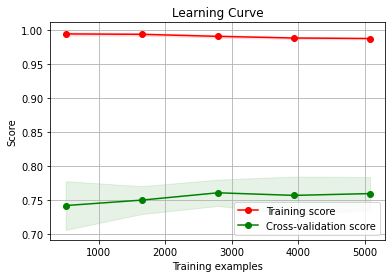

In [173]:
import catboost as ctb
from scikitplot.estimators import plot_learning_curve
X_train = np.load("train_X_topic_text_clean.npy")
X_test = np.load("test_X_topic_text_clean.npy")

y_train = train2['target'].values

model = ctb.CatBoostClassifier(max_depth=8, n_estimators=100, verbose=0, random_state=0, custom_metric='AUC')
model.fit(X_train, y_train)
plot_learning_curve(model, X_train, y_train, cv=3, random_state=2019, shuffle=True)

In [174]:
test3['target'] = model.predict(X_test).astype('int32')
test3[ ['id', 'target'] ].to_csv('bert_tp.csv', index=False)

Kaggle score: 0.77903